$$\Huge\textbf{Decision Tree Models}$$

# Imports

In [2]:
# Standard library imports
import os  # directory and file operations
import shutil  # copying files
import time  # adding delays

# Installed library imports
import numpy as np  # numerical operations
import matplotlib.pyplot as plt  # plotting and visualization
import pandas as pd
from PIL import Image  # image processing
import seaborn as sns  # confusion matrix visualization
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix  # evaluation metrics
from sklearn.model_selection import StratifiedKFold, train_test_split  # splitting datasets and cross-validation
from sklearn.tree import DecisionTreeClassifier  # decision tree classifier
import torchvision.transforms as transforms  # data augmentation
from sklearn.preprocessing import StandardScaler #
from sklearn.pipeline import Pipeline
from skimage.io import imread
from skimage.transform import resize


# Global Constansts

In [3]:
# constants
NUM_IMAGES_PER_CLASS = 1000
TEST_SPLIT_PERCENTAGE = 0.15
TRAIN_VAL_SPLIT_PERCENTAGE = 1 - TEST_SPLIT_PERCENTAGE  # the rest is for training and validation
BATCH_SIZE = 100  # number of images to copy at once
RANDOM_SEED = 42  # seed for reproducibility

IMAGE_SIZE = (256, 256)
VALIDATION_SPLIT = 15 / 85  # train_val is 85% of the total dataset, we want the validation set to be 15% of the total dataset
CLASSES = ['airplane_cabin', 'hockey_arena', 'movie_theater', 'staircase', 'supermarket']

In [ ]:
# data directories
PROJECT_DATASET_DIR = '/content/drive/MyDrive/project_dataset'
PROJECT_OUTPUT_DIR = '/content/drive/MyDrive/project_output'
CLASSES_ORIGINAL = ['airplane_cabin', 'hockey_arena', 'movie_theater', 'staircase', 'supermarket']
CLASSES_NEW = ['airplane_cabin', 'hockey_arena', 'movie_theater', 'staircase', 'supermarket']

TRAIN_VAL_DIR = os.path.join(PROJECT_DATASET_DIR, 'train_val')
TEST_DIR = os.path.join(PROJECT_DATASET_DIR, 'test')

TRAIN_DIR = os.path.join(PROJECT_DATASET_DIR, 'train')  # new directory
VALIDATION_DIR = os.path.join(PROJECT_DATASET_DIR, 'validation')  # new directory
CROSS_VALI_DIR = os.path.join(PROJECT_DATASET_DIR, 'cross_validation') # new directory for cross_validation

In [7]:
# please do not remove it, it's for test purpose!!

# data directories
CLASSES_ORIGINAL = ['airplane_cabin', 'hockey_arena', 'movie_theater', 'staircase', 'supermarket']
CLASSES_NEW = ['airplane_cabin', 'hockey_arena', 'movie_theater', 'staircase', 'supermarket']

# processed data directories: case without cross validation
PROCESSED_DATA_DIR = r'C:\Users\helen\Documents\Concordia University\summer 2024\COMP 6721\project_code\data\project_dataset\processed_data'
TEST_DIR = os.path.join(PROCESSED_DATA_DIR, 'without_cross_validation', 'test')
TRAIN_DIR = os.path.join(PROCESSED_DATA_DIR, 'without_cross_validation','train') 
VALIDATION_DIR = os.path.join(PROCESSED_DATA_DIR, 'without_cross_validation', 'validation')  # new directory

# project output directory
PROJECT_OUTPUT_DIR = r'C:\Users\helen\Documents\Concordia University\summer 2024\COMP 6721\project_code\data\project_output'


# 1. Help Functions

## 1.1. Load image data and labels for each dataset.


*   Number of training data: 14000
*   Number of validation/test data: 750





In [5]:
def load_images_and_labels(base_dir):
    """
    Load image data and labels from a specified directory. This function traverses each class directory, loads each image, and assigns labels based on the directory name.

    Inputs:
    - base_dir: A string, the path to the directory containing subdirectories for each class.

    Outputs:
    - A tuple containing two numpy arrays:
      1. `data`: an array of flattened image data.
      2. `labels`: an array of labels corresponding to the images.

    Each class is expected to have its own subdirectory within `base_dir` with the name of the class.
    """
    # Initialize lists to store image data and labels
    data = []
    labels = []

    # Define the classes and create a mapping from class names to a unique integer
    classes = ['airplane_cabin', 'hockey_arena', 'movie_theater', 'staircase', 'supermarket']
    class_labels = {cls_name: idx for idx, cls_name in enumerate(classes)}

    # Iterate over each class directory in the base directory
    for cls_name in classes:
        class_dir = os.path.join(base_dir, cls_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = Image.open(img_path)  # Open the image directly
            img_data = np.array(img).flatten()  # Flatten the image data into a one-dimensional vector
            data.append(img_data)
            labels.append(class_labels[cls_name])

    # Convert the lists of data and labels to numpy arrays and return
    return np.array(data), np.array(labels)

In [6]:
# Load training, validation, and test data
train_data, train_labels = load_images_and_labels(TRAIN_DIR)
validation_data, validation_labels = load_images_and_labels(VALIDATION_DIR)
test_data, test_labels = load_images_and_labels(TEST_DIR)

## 1.2. Generate CSV file

In [8]:
def generate_csv_filename(max_depth, min_samples_split, min_samples_leaf, criterion):
    """
    Generate a filename for storing CSV data based on the parameters of a decision tree model.

    Parameters:
    - max_depth (int or None): The maximum depth of the tree.
    - min_samples_split (int): The minimum number of samples required to split an internal node.
    - min_samples_leaf (int): The minimum number of samples required to be at a leaf node.
    - criterion (str): The function to measure the quality of a split.

    Returns:
    - str: A string representing the filename.
    """
    # Replace None with 'None' for filename compatibility
    max_depth_str = 'None' if max_depth is None else max_depth

    # Construct the filename
    filename = f"d{max_depth_str}_s{min_samples_split}_l{min_samples_leaf}_{criterion}.csv"

    return filename

# 2. Evaluation Metrics

In [9]:
def evaluate_model(predictions, true_labels):
    """
    Evaluate the predictions of a model using the true labels.
    Calculate the accuracy, precision, recall, and confusion matrix of the predictions.

    Inputs:
    - predictions (np.ndarray): The predicted labels from the model.
    - true_labels (np.ndarray): The true labels for the validation data.

    Outputs:
    - accuracy (float): The accuracy of the model on the validation data.
    - precision (float): The precision of the model on the validation data.
    - recall (float): The recall of the model on the validation data.
    - conf_matrix (np.ndarray): The confusion matrix of the model's predictions.
    """
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    
    # Calculate precision (macro-average for multi-class classification)
    precision = precision_score(true_labels, predictions, average='macro')
    
    # Calculate recall (macro-average for multi-class classification)
    recall = recall_score(true_labels, predictions, average='macro')
    
    # Generate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions)

    return accuracy, precision, recall, conf_matrix


In [10]:
def print_evaluation_results(accuracy, precision, recall, conf_matrix, class_labels):
    """
    Print and plot the evaluation results.

    Inputs:
    - accuracy (float): The accuracy of the model.
    - precision (float): The precision of the model.
    - recall (float): The recall of the model.
    - conf_matrix (np.ndarray): The confusion matrix of the model's predictions.
    - class_labels (np.ndarray): The unique class labels.

    No outputs. The function prints the evaluation metrics and plots the confusion matrix.
    """
    # Print the evaluation metrics
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    
    # Print the confusion matrix
    print("Confusion Matrix:")
    print(conf_matrix)
    
    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# 3. Decision Tree Models

## 3.1. Supervised Decision Tree

In [11]:
# Create a decision tree model
model_dt = DecisionTreeClassifier(max_depth=10, 
                                  min_samples_split=20, 
                                  min_samples_leaf=2, 
                                  criterion='entropy', 
                                  random_state=RANDOM_SEED)

model_dt.fit(train_data, train_labels)

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=2,
                       min_samples_split=20, random_state=42)

In [ ]:
# Evaluate the model using training data
train_predictions_dt = model_dt.predict(train_data)
train_accuracy_dt = accuracy_score(train_labels, train_predictions_dt)
print(f'Training Accuracy for model_dt2: {train_accuracy_dt}')

# Evaluate the model using validation data
validation_predictions_dt = model_dt.predict(validation_data)
vali_accuracy_dt = accuracy_score(validation_labels, validation_predictions_dt)
print(f'Validation Accuracy for model_dt2: {vali_accuracy_dt}')

Accuracy: 0.482
Precision: 0.5546143081761012
Recall: 0.48199999999999993
Confusion Matrix:
[[604  49  96 120 531]
 [108 471 108 135 578]
 [ 61  21 866 100 352]
 [116  72  79 457 676]
 [123  84  70 147 976]]


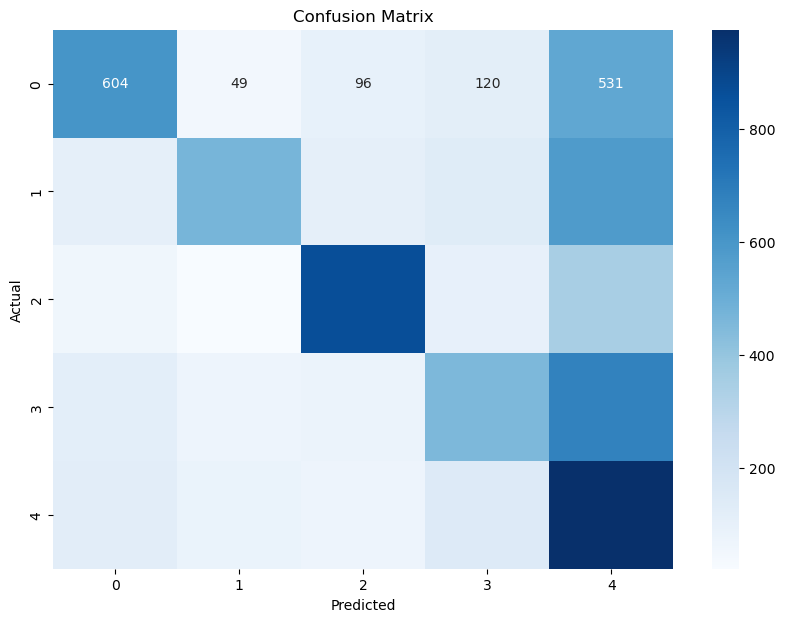

Accuracy: 0.17333333333333334
Precision: 0.1726535229476406
Recall: 0.17333333333333334
Confusion Matrix:
[[ 24  22  19  13  72]
 [ 27  16  25  12  70]
 [ 20   8  10  10 102]
 [ 24  19  19  11  77]
 [ 24  20  27  10  69]]


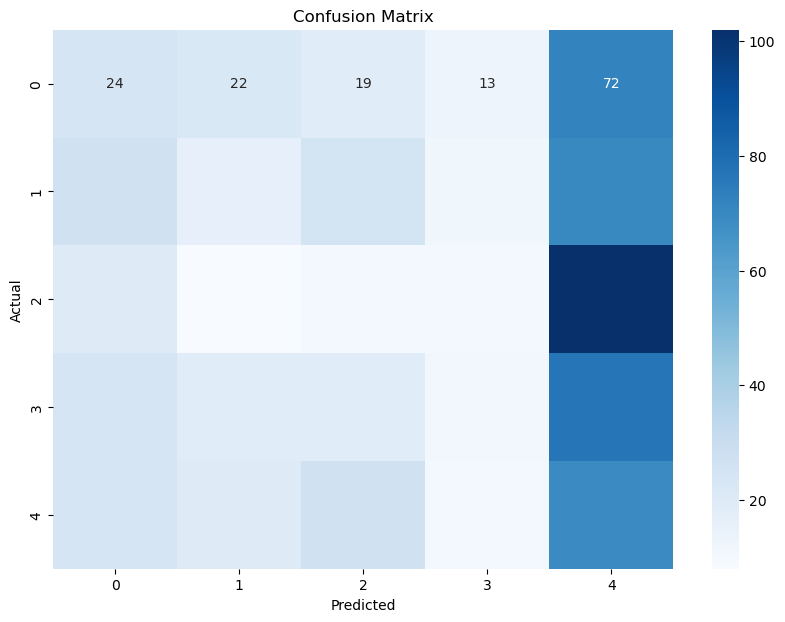

In [13]:
### test purpose, please do not delete!
# Use the trained model to predict 
train_predictions_dt = model_dt.predict(train_data)
validation_predictions_dt = model_dt.predict(validation_data)

# Evaluate the model using the evaluate_model(predictions, true_labels) function
train_accuracy_dt, train_precision_dt, train_recall_dt, train_conf_matrix_dt = evaluate_model(train_predictions_dt, train_labels)
val_accuracy_dt, val_precision_dt, val_recall_dt, val_conf_matrix_dt = evaluate_model(validation_predictions_dt, validation_labels)

# Print and plot the evaluation results
print_evaluation_results(train_accuracy_dt, train_precision_dt, train_recall_dt, train_conf_matrix_dt, np.unique(train_labels))
print_evaluation_results(val_accuracy_dt, val_precision_dt, val_recall_dt, val_conf_matrix_dt, np.unique(validation_labels))

In [ ]:
# Save the labels and predictions to a CSV file
results_df = pd.DataFrame({
    'Actual Labels': validation_labels,
    'Predicted Labels': validation_predictions_dt
})

# File path for the CSV file
filename = generate_csv_filename(10, 20, 2, 'entropy')
csv_file_path = os.path.join(PROJECT_OUTPUT_DIR, 'csvs/'+filename)

# Check if the file exists, if not create one, if yes append without writing headers
if not os.path.isfile(csv_file_path):
    results_df.to_csv(csv_file_path, index=False)
else:
    results_df.to_csv(csv_file_path, mode='a', header=False, index=False)

## 3.2. Supervised Decision Tree with 5-fold validation

There is a directory for cross validation.

In [ ]:
def prepare_cross_validation_dirs(base_dir, output_dir, n_splits=5):
    """
    Prepares cross-validation directories for image data.
    
    Parameters:
    - base_dir: Path to the directory containing the original unnormalized, unaugmented data.
    - output_dir: Path to the directory where the cross-validation splits will be stored.
    - n_splits: Number of cross-validation splits.
    """
    # Create the cross_validation directory if it does not exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Read all images and their labels
    images, labels = [], []
    class_folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]
    for folder in class_folders:
        folder_path = os.path.join(base_dir, folder)
        for img in os.listdir(folder_path):
            if img.lower().endswith(('.png', '.jpg', '.jpeg')):
                images.append(os.path.join(folder, img))
                labels.append(folder)

    # Prepare stratified splits
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    images = np.array(images)
    labels = np.array(labels)

    # Generate splits and directories
    for fold, (train_idx, val_idx) in enumerate(skf.split(images, labels), 1):
        fold_dir = os.path.join(output_dir, f'fold_{fold}')
        os.makedirs(fold_dir, exist_ok=True)

        # Directories for training and validation inside each fold
        train_dir = os.path.join(fold_dir, 'train')
        val_dir = os.path.join(fold_dir, 'val')
        os.makedirs(train_dir, exist_ok=True)
        os.makedirs(val_dir, exist_ok=True)

        # Copy training images
        for img in images[train_idx]:
            src = os.path.join(base_dir, img)
            dst = os.path.join(train_dir, img)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            shutil.copy(src, dst)

        # Copy validation images
        for img in images[val_idx]:
            src = os.path.join(base_dir, img)
            dst = os.path.join(val_dir, img)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            shutil.copy(src, dst)

In [ ]:
base_dir = os.path.join(PROJECT_DATASET_DIR, 'train_val') 
output_dir =os.path.join(PROJECT_DATASET_DIR, 'cross_validation') 
prepare_cross_validation_dirs(base_dir, output_dir)

In [ ]:
# here we just temporary use the raw pictures to test †he training of 5-fold
# will modify these when have the processed cross_vali datasets
def load_images_from_folder(folder):
    images = []
    labels = []
    for class_folder in os.listdir(folder):
        class_folder_path = os.path.join(folder, class_folder)
        for filename in os.listdir(class_folder_path):
            img_path = os.path.join(class_folder_path, filename)
            img = imread(img_path)
            images.append(img)
            labels.append(class_folder)
    return np.array(images), np.array(labels)

def train_decision_tree(train_dir, val_dir):
    # Load images and labels
    X_train, y_train = load_images_from_folder(train_dir)
    X_val, y_val = load_images_from_folder(val_dir)

    # Define the decision tree model
    model = Pipeline([
        ('scaler', StandardScaler()),  # Scale images
        ('classifier', DecisionTreeClassifier(max_depth=10, min_samples_split=20, min_samples_leaf=2, criterion='entropy'))
    ])
    # Train the model
    model.fit(X_train.reshape(X_train.shape[0], -1), y_train)  # Flatten images for training

    # Calculate training accuracy
    y_train_pred = model.predict(X_train.reshape(X_train.shape[0], -1))
    train_accuracy = accuracy_score(y_train, y_train_pred)

    # Predict the validation set
    y_vali_pred = model.predict(X_val.reshape(X_val.shape[0], -1))

    # Calculate validation accuracy
    val_accuracy = accuracy_score(y_val, y_vali_pred)
    return train_accuracy, val_accuracy

In [ ]:
train_accuracies = []
val_accuracies = []
for i in range(1, 6):  # 5 folds
    train_dir = os.path.join(CROSS_VALI_DIR, f'fold_{i}', 'train')
    val_dir = os.path.join(CROSS_VALI_DIR, f'fold_{i}', 'val')
    train_accuracy, val_accuracy = train_decision_tree(train_dir, val_dir)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    print(f"Training Accuracy for fold {i}: {train_accuracy}")
    print(f"Validation Accuracy for fold {i}: {val_accuracy}")

## 3.3. Semi-Supervised Decision Tree

### 3.3.1. Generating the labeled and unlabeled data for Semi-Supervised Decision Tree

In [ ]:
def load_images_and_split(base_dir, labeled_ratio=0.2):
    """
    Load images from a directory and split them into labeled and unlabeled datasets.

    Args:
    - base_dir (str): Path to the directory containing subdirectories for each class.
    - labeled_ratio (float): The fraction of data to keep as labeled.

    Returns:
    - labeled_data (np.array): Array of labeled data.
    - labeled_labels (list): List of labels for the labeled data.
    - unlabeled_data (np.array): Array of unlabeled data.
    """
    data = []
    labels = []
    classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    class_labels = {cls_name: idx for idx, cls_name in enumerate(classes)}

    # Load all data and labels
    for cls_name in classes:
        class_dir = os.path.join(base_dir, cls_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = Image.open(img_path)
            img_data = np.array(img).flatten()
            data.append(img_data)
            labels.append(class_labels[cls_name])

    # Convert to numpy arrays
    data = np.array(data)
    labels = np.array(labels)

    # Split into labeled and unlabeled
    labeled_indices, unlabeled_indices = train_test_split(
        np.arange(len(labels)),
        test_size=1-labeled_ratio,
        random_state= RANDOM_SEED,
        stratify=labels  # Keep the distribution of classes consistent
    )

    labeled_data = data[labeled_indices]
    labeled_labels = labels[labeled_indices]
    unlabeled_data = data[unlabeled_indices]

    return labeled_data, labeled_labels, unlabeled_data

In [ ]:
labeled_data, labeled_labels, unlabeled_data = load_images_and_split(TRAIN_DIR, labeled_ratio=0.2)

print("Labeled data shape:", labeled_data.shape)
print("Unlabeled data shape:", unlabeled_data.shape)

### 3.3.2. Model Training

 *need to add validation*

In [ ]:
# Create the decision tree model
model = DecisionTreeClassifier(random_state = RANDOM_SEED)

# Initial training: Use the labeled data to train the model
model.fit(labeled_data, labeled_labels)

# Threshold list: decrease from 95% to 90% to 85% to 80%
thresholds = [0.95, 0.90, 0.85, 0.80]
test_accuracies = []  # Store the test accuracy for each threshold
train_accuracies = []  # Store the training accuracy for each threshold

# Iterate through each threshold
for confidence_threshold in thresholds:
    pseudo_labels = []  # Reset the pseudo label list for each loop

    # Predict the labels for the unlabeled data
    probabilities = model.predict_proba(unlabeled_data)
    max_probabilities = np.max(probabilities, axis=1)

    # Select high-confidence predictions to use as pseudo labels
    for i, prob in enumerate(max_probabilities):
        if prob > confidence_threshold:
            pseudo_labels.append((unlabeled_data[i], np.argmax(probabilities[i])))

    # If there are enough high-confidence predictions, add them as pseudo labels to the training data
    if pseudo_labels:
        pseudo_data, pseudo_labels = zip(*pseudo_labels)
        new_data = np.vstack([labeled_data] + list(pseudo_data))
        new_labels = np.hstack([labeled_labels] + list(pseudo_labels))

        # Retrain the model with the new training data including pseudo labels
        model.fit(new_data, new_labels)

    # Calculate and store training accuracy
    train_accuracy = model.score(new_data, new_labels)
    train_accuracies.append(train_accuracy)

    # Measure the model's performance on the original labeled test set
    test_accuracy = model.score(test_data, test_labels)
    test_accuracies.append(test_accuracy)
    print(f'Training Accuracy at threshold {confidence_threshold*100}%: {train_accuracy}')
    print(f'Test Accuracy at threshold {confidence_threshold*100}%: {test_accuracy}')


# Plot the test and training accuracies
plt.figure(figsize=(10, 6))
plt.plot([str(th*100) for th in thresholds], test_accuracies, marker='o', linestyle='-', color='b', label='Test Accuracy')
plt.plot([str(th*100) for th in thresholds], train_accuracies, marker='x', linestyle='--', color='r', label='Training Accuracy')
plt.title('Accuracy vs Confidence Threshold')
plt.xlabel('Confidence Threshold (%)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


## 3.4. Semi-Supervised Decision Tree with 5-fold validation